<a href="https://colab.research.google.com/github/pandaharya/paper-insect/blob/main/EfficienetB2_Batik_daripapua%20Kombinasi%20Letak.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [359]:
!pip install geffnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### **Import Necessary Libraries:**

In [360]:
import numpy as np
import pandas as pd
import glob
import math
import os
import torch
import random
from torchvision import datasets, transforms, models
from torch import nn, optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
 
import geffnet

In [361]:
!nvidia-smi

Mon Aug  1 09:31:15 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    34W / 250W |   3025MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [362]:
# For mounting Google drive, as I was using Google Collab and my Dataset was in Google drive
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive


In [363]:
# Get the total number of images in each class
file_count = 0
classes = os.listdir("/content/gdrive/MyDrive/motifbatikpapua3/val")
for cat in ['train', 'val', 'test']:
  files = glob.glob('/content/gdrive/MyDrive/motifbatikpapua3/'+cat+'/*/*')
  print(cat,'Images:',len(files), end = ', ')
print('\n')
for direc in classes:
  files = glob.glob('/content/gdrive/MyDrive/motifbatikpapua3/*/'+direc+'/*')
  file_count += len(files)
  print(direc, len(files))
print(file_count)

train Images: 177, val Images: 23, test Images: 24, 

motif asmat 67
motif cendrawasih 51
motif raja ampat 53
motif tifa honai 53
224


## **Load The Data**

In [364]:
from torchvision.transforms.transforms import RandomCrop
data_dir = '/content/gdrive/MyDrive/motifbatikpapua3'
random.seed(41)

#Data Tranforms (Augmentation and Normalization)
train_transforms = transforms.Compose([
                                       transforms.RandomResizedCrop(size = (200,150), scale=(0.08,1.0), ratio=(0.75, 1.3333333333333333)),
                                       transforms.RandomRotation(45),
                                       #transforms.ColorJitter(brightness=.4, contrast=.4, saturation=.4, hue=.4),
                                       transforms.RandomAffine(degrees=(30, 70), translate=(0.1, 0.3), scale=(0.5, 0.75)),
                                       #transforms.RandomInvert(),
                                       #transforms.RandomGrayscale(),
                                       #transforms.RandomPosterize(bits=5, p=1.0),
                                       #transforms.RandomSolarize(threshold=0.5),
                                       #transforms.RandomAdjustSharpness(sharpness_factor=50, p=1.0),
                                       #transforms.RandomAutocontrast(p=1.0), 
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomVerticalFlip(),
                                       transforms.Resize(size=(224,224)),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])])
val_transforms = transforms.Compose([
                                       #transforms.RandomRotation(45),
                                       #transforms.RandomHorizontalFlip(0.6),
                                       transforms.Resize(size=(224,224)),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])])
test_transforms = transforms.Compose([transforms.Resize(size=(224,224)),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])])

#Getting all the data with PyTorch Datasets
train_data = datasets.ImageFolder(data_dir + '/train', transform= train_transforms)
val_data = datasets.ImageFolder(data_dir + '/val', transform= val_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform= test_transforms)

#Loading the data into PyTorch DataLoader
train_loader = torch.utils.data.DataLoader(train_data, batch_size= 64, shuffle = True,num_workers=2)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size= 64, shuffle = True,num_workers=2)
test_loader = torch.utils.data.DataLoader(test_data, batch_size= 64, shuffle = True,num_workers=2)

#Creating a dictionary of all classes
classes = dict(zip(list(range(len(train_data.classes))),train_data.classes))

### **Check the images with labels**

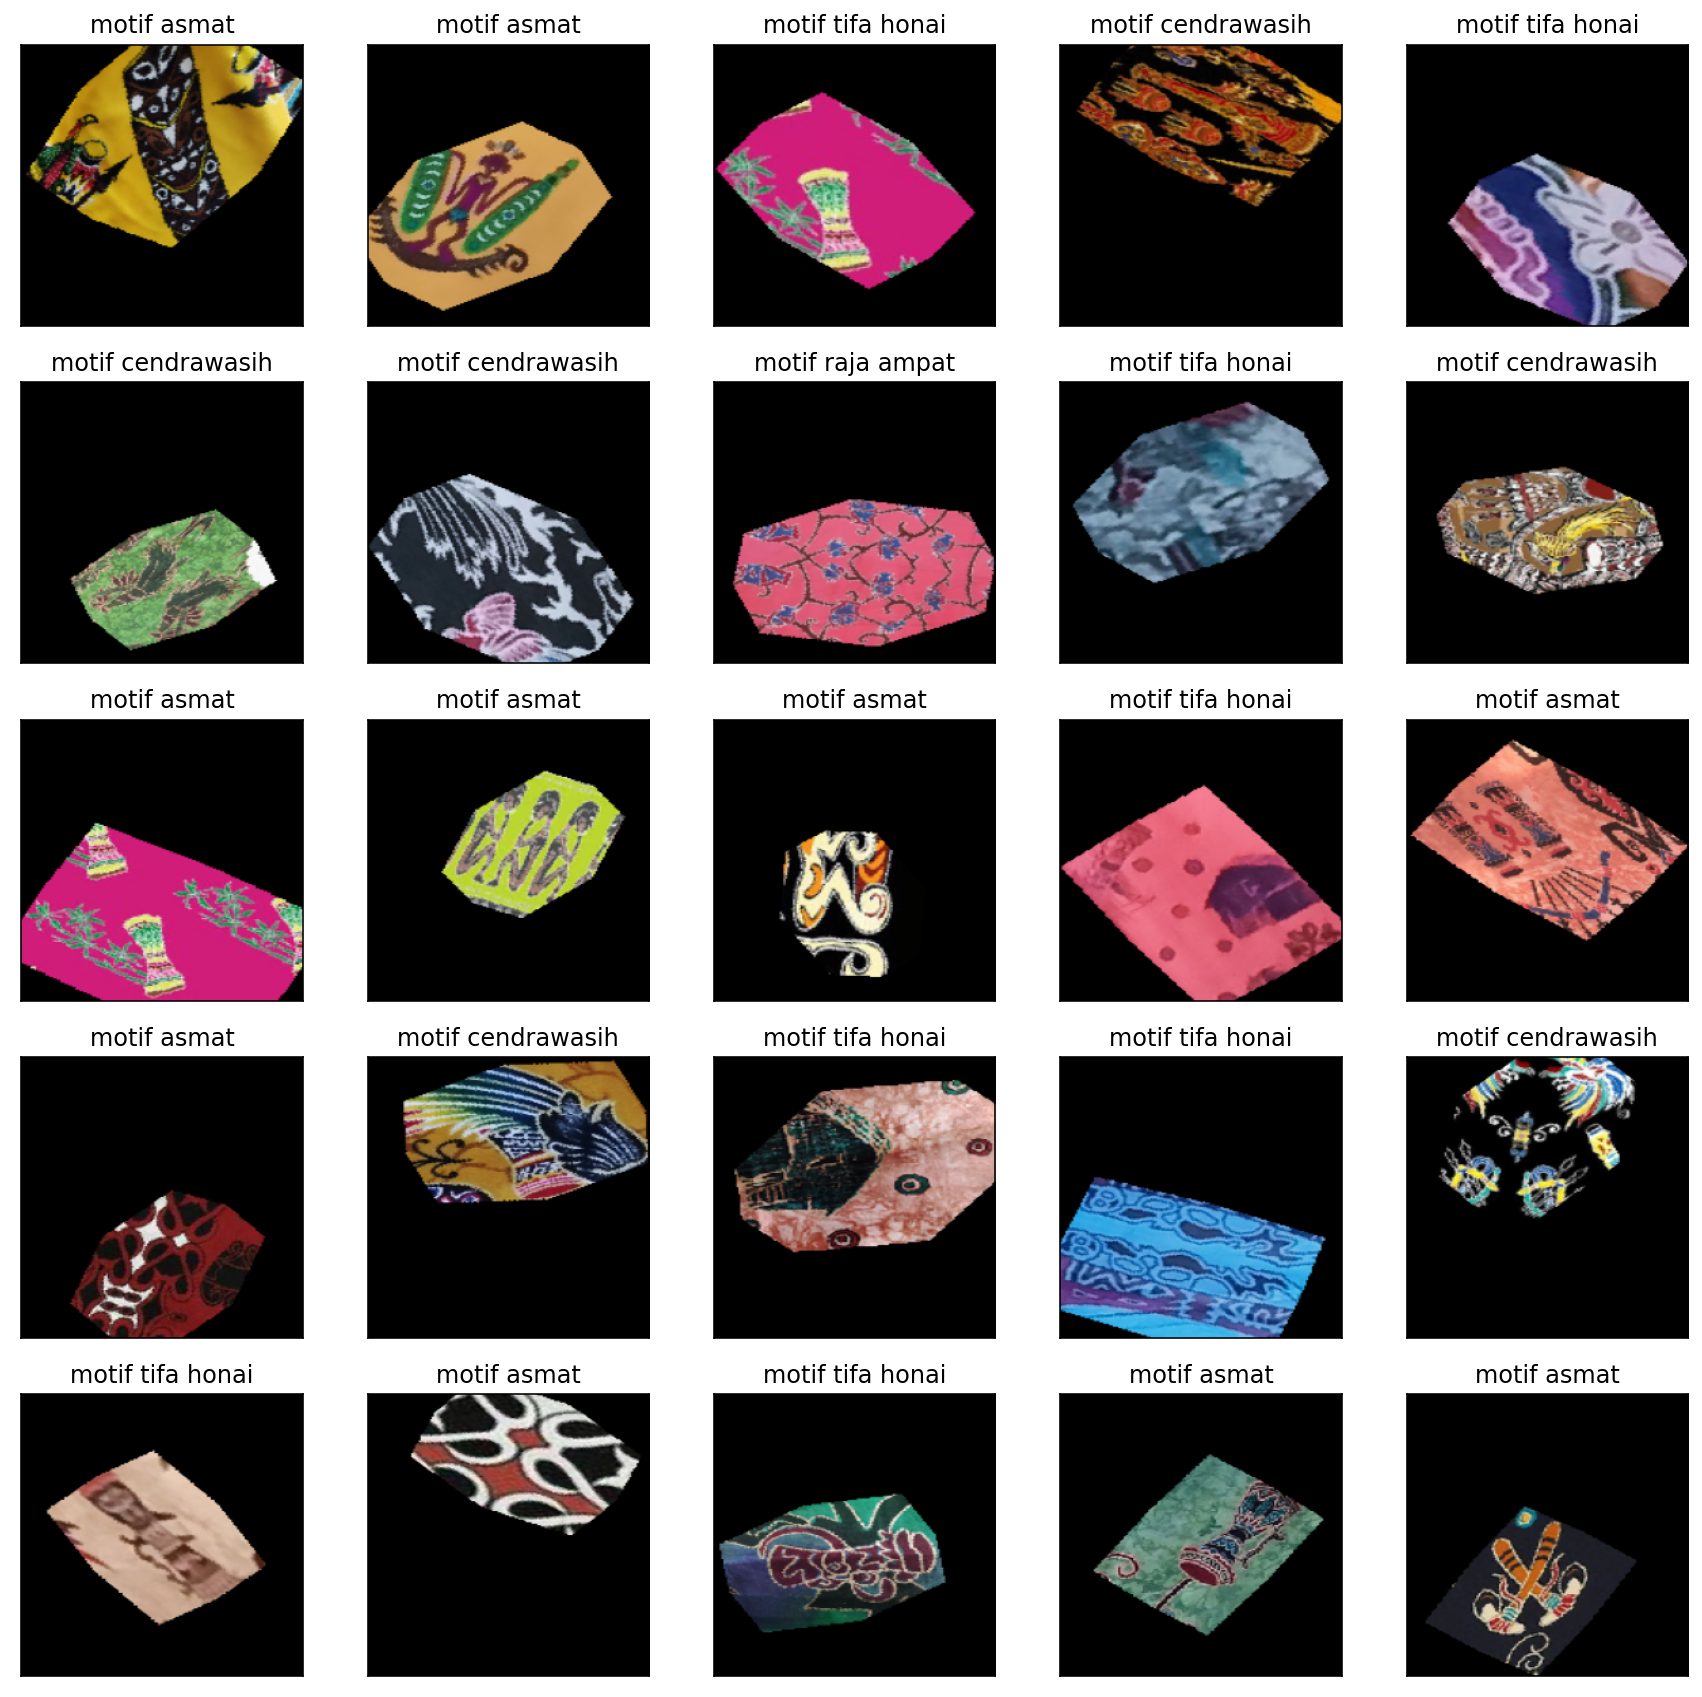

In [365]:
def denormalise(image):
  try:
    image = image.cpu().numpy().transpose(1, 2, 0)
  except:
    image = image.transpose(1, 2, 0) # PIL images have channel last
  mean = [0.485, 0.456, 0.406]
  stdd = [0.229, 0.224, 0.225]
  image = (image * stdd + mean).clip(0, 1)
  return image

dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()
fig = plt.figure(figsize=(15,15))

for idx in np.arange(25):
  ax = fig.add_subplot(5, 5, idx+1, xticks=[], yticks=[])
  ax.imshow(denormalise(images[idx]), cmap='gray')
  ax.set_title(classes[labels[idx].item()])

## **Load the model**

In [366]:
# Specify the device type
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [367]:
# Loading the model
model = geffnet.create_model('efficientnet_b2', pretrained=True)

#Freezing all the layers
for param in model.parameters():
  param.requires_grad = False 

# Changing the Classifier
model.classifier = nn.Sequential(nn.Linear(1408,512),
                           nn.ReLU(),
                           nn.Dropout(p=0.4),
                           nn.Linear(512,128),
                           nn.ReLU(),
                           nn.Dropout(p=0.4),
                           nn.Linear(128,len(classes)))

# Making the Classifier layer Trainable                           
for param in model.classifier.parameters():
  param.requires_grad = True

# Moving the model to device
model.to(device)

GenEfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SiLU(inplace=True)
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
      )
      (1): Depthwise

### **Specify the Loss Criterion, Optimizer and Scheduler**

In [368]:
criterion = nn.CrossEntropyLoss()
optimizer  = optim.Adam(model.classifier.parameters(),lr = 0.01)
scheduler = StepLR(optimizer, step_size=6, gamma=0.35)

## **Train The Model**

In [369]:
epochs = 100 # Number of epochs
steps = 0
print_every = 5 
train_losses, valid_losses,valid_acc = [], [], [] # List keeping track of losses and accuracy to plot later
valid_loss_min = np.Inf # It will be used to save model whenever Vallidation loss decreases
valid_acc_min = 0.0 

for e in range(epochs):
  
  train_loss = 0 
  model.train()
  #train the model
  for images, labels in train_loader:
    steps+=1
    # Move tensor to device('cuda' in case of GPU or 'cpu' in case of CPU)
    images, labels = images.to(device), labels.to(device)
    # Clearing all the previous gradients
    optimizer.zero_grad()
    # Forward Pass
    logits = model(images)
    # Loss calculation
    loss = criterion(logits,labels)
    # Backward Pass
    loss.backward()
    # Update the parameters
    optimizer.step()
    # Updating the losses list
    train_loss += loss.item()

    # Evaluating after specific amount of steps
    if steps % print_every == 0:
      valid_loss = 0
      accuracy = 0
      # Setting Model to Evaluation Mode
      model.eval()
      with torch.no_grad():
        # Getting Validation loss
        for images, labels in valid_loader:
          images, labels = images.to(device), labels.to(device)
          logits = model(images)
          batch_loss = criterion(logits,labels)
          valid_loss += batch_loss.item()
          
          # Calculating Accuracy
          output = F.softmax(logits,dim=1)
          top_p,top_class = output.topk(1,dim = 1)
          equals = top_class == labels.view(*top_class.shape)
          accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
      # Printing stats    
      print(f"Epoch {e+1}/{epochs}.. "
                  f"Train loss: {train_loss/print_every:.3f}.. "
                  f"Validation loss: {valid_loss/len(valid_loader):.3f}.. "
                  f"Validation accuracy: {accuracy/len(valid_loader):.3f}.. "
                  f"LR : {scheduler.get_lr():}"
                  )
      valid_loss = valid_loss/len(valid_loader)
      train_losses.append(train_loss/print_every)
      valid_losses.append(valid_loss)
      valid_acc.append(accuracy/len(valid_loader))
      
      # Checking if Validation loss decreased
      if valid_loss <= valid_loss_min:
        
        # if decreased, it will save the model
        print('valid loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss
      
      
  # Scheduler performing a step to change learning rate of Optimizer    
  scheduler.step()

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:372: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Epoch 2/100.. Train loss: 0.629.. Validation loss: 1.325.. Validation accuracy: 0.364.. LR : [0.01]
valid loss decreased (inf --> 1.324853).  Saving model ...
Epoch 4/100.. Train loss: 0.219.. Validation loss: 1.112.. Validation accuracy: 0.636.. LR : [0.01]
valid loss decreased (1.324853 --> 1.112004).  Saving model ...
Epoch 5/100.. Train loss: 0.661.. Validation loss: 0.895.. Validation accuracy: 0.727.. LR : [0.01]
valid loss decreased (1.112004 --> 0.895127).  Saving model ...
Epoch 7/100.. Train loss: 0.407.. Validation loss: 0.829.. Validation accuracy: 0.727.. LR : [0.0012249999999999997]
valid loss decreased (0.895127 --> 0.829289).  Saving model ...
Epoch 9/100.. Train loss: 0.161.. Validation loss: 0.856.. Validation accuracy: 0.682.. LR : [0.0034999999999999996]
Epoch 10/100.. Train loss: 0.486.. Validation loss: 0.909.. Validation accuracy: 0.682.. LR : [0.0034999999999999996]
Epoch 12/100.. Train loss: 0.338.. Validation loss: 0.878.. Validation accuracy: 0.682.. LR : [0.

### **Analysis of Training and Validation Losses and Accuracy**

In [370]:
model.load_state_dict(torch.load("/content/gdrive/MyDrive/model.pt"))

<All keys matched successfully>

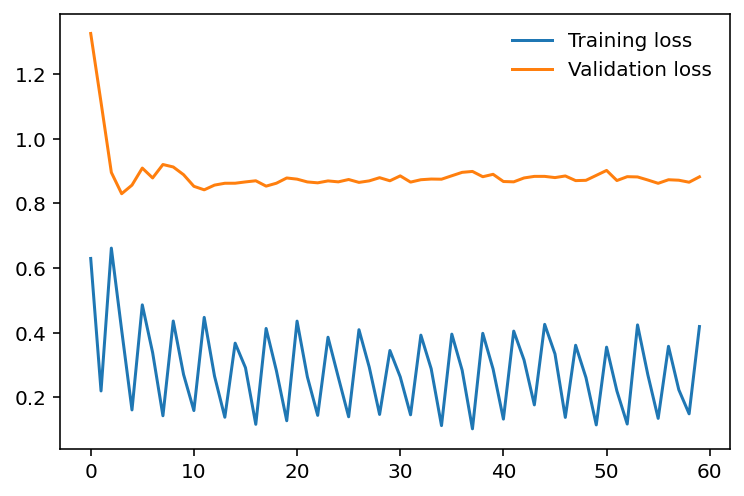

In [371]:
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend(frameon=False)

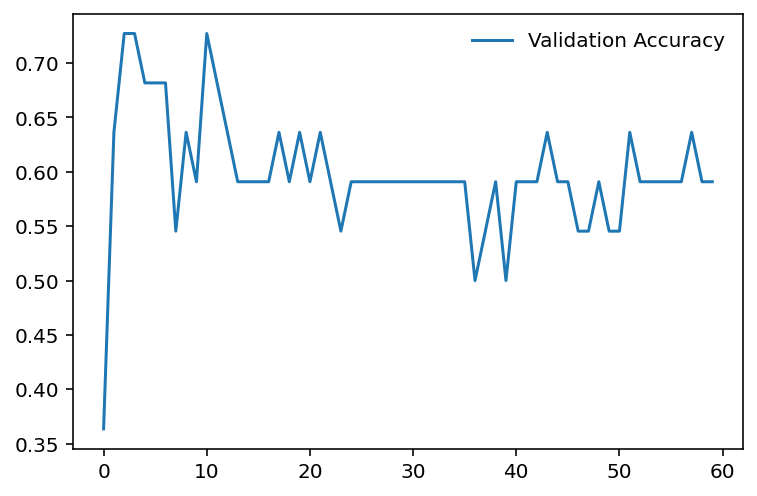

In [372]:
plt.plot(valid_acc, label='Validation Accuracy')
plt.legend(frameon=False)

## **Model Evaluation**

In [373]:
model.eval() # Prep model for Evaluation

mean_of = 5 # Mean of how many evaluations
valid_loss = 0.0
class_correct = list(0. for i in range(len(classes))) # List of number of correct predictions in each class
class_total = list(0. for i in range(len(classes))) # List of total number of samples in each class

for i in range(mean_of):
  for data, target in test_loader:
    # Move the data to device
    data, target = data.to(device), target.to(device)
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    valid_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    
    # calculate test accuracy for each object class
    for i in range(len(target)):    
        label = target.data[i]
        if len(target) == 1:
          class_correct[label] += correct.item()
        else:
          class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print average test loss
valid_loss = valid_loss/(mean_of * len(test_loader.dataset))
print('Test Loss: {:.6f}\n'.format(valid_loss))

# print accuracy of each class
for i in range(len(classes)):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %0.2f%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))
acc = 100. * np.sum(class_correct) / np.sum(class_total)

# print total accuracy of the model
print('\nTest Accuracy (Overall): %0.2f%% (%2d/%2d)' % (
    acc,
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.799753

Test Accuracy of     0: 100.00% (30/30)
Test Accuracy of     1: 80.00% (20/25)
Test Accuracy of     2: 66.67% (20/30)
Test Accuracy of     3: 60.00% (15/25)

Test Accuracy (Overall): 77.27% (85/110)


'motif raja ampat'

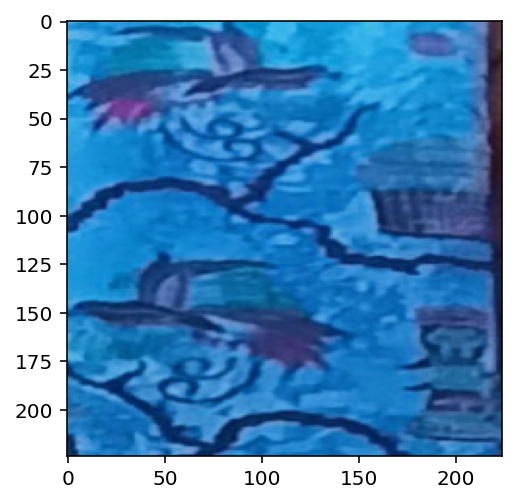

In [374]:
## To check on a custom Image

img = Image.open('/content/gdrive/MyDrive/motifbatikpapua3/test/motif cendrawasih/cen07.jpg')
# Convert 2D image to 1D vector
images = test_transforms(img)

plt.imshow(denormalise(images))
# Calculate the class probabilities (softmax) for img
with torch.no_grad():
  images = images.to(device)
  output = model(images.unsqueeze(0))

ps = F.softmax(output, dim =1 )

classes[int(torch.argmax(ps).item())]

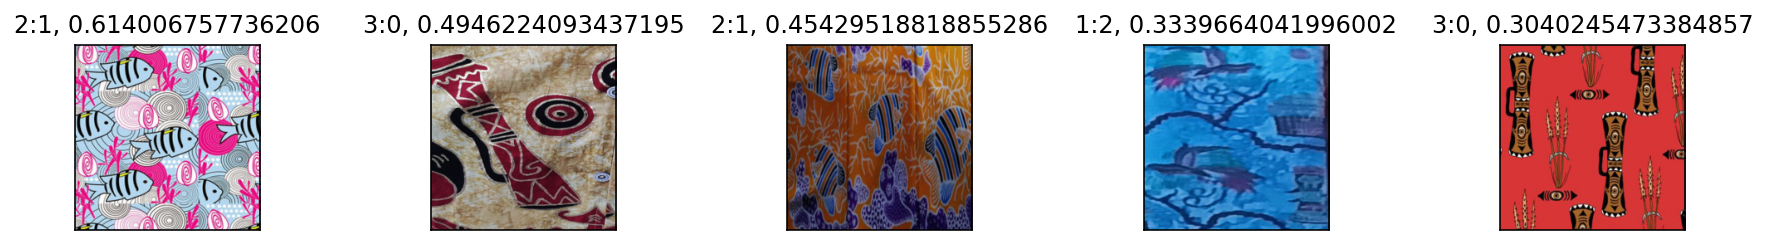

In [375]:
# Check which images, the model predicted incorrectly with correct and predicted label and the probability

classes
dataiter = iter(test_loader)
images, labels = dataiter.next()
with torch.no_grad():
  images, labels = images.to(device), labels.to(device)
  output = model(images)

ps = F.softmax(output, dim =1 )

#images = images.cpu().numpy()


fig = plt.figure(figsize=(25,16))
i = 1
for idx in np.arange(22):
  pred = torch.argmax(ps[idx]).item()
  prob = ps[idx][pred]
  if labels[idx].item() != pred:
    ax = fig.add_subplot(8, 64/8, i, xticks=[], yticks=[])
    ax.imshow(denormalise(images[idx]), cmap='gray')
    ax.set_title((str(labels[idx].item())+':'+str(pred))+', '+str(prob.item()))
    i+=1